In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols, simplify
from sympy import init_printing, latex
from sympy import S
from scipy.integrate import odeint
import numpy as np
init_printing(latex)

In [2]:
import math
import numpy as np

def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

def LaplaceCoefficient(s,j,a,n):
    j = abs(j)
    outside = 1
    for k in range(j):
        outside *= s+k
    outside *= 2./math.factorial(j)*a**(j-n)
    cterm = 1.
    cbterm = 1.
    for k in range(n):
        cbterm *= (j-k)
    csum = cbterm
    i=1
    while cbterm > np.finfo(float).eps or cbterm == 0:
        cterm = cterm*(s+i-1)*(s+j+i-1)/i/(j+i)*a**2
        cbterm = cterm
        for k in range(n):
            cbterm *= j+2*i-k
        csum += cbterm
        i+=1
    return outside*csum

def transform(lambda1, lambda2, alpha, prefac):
    s=0
    for j in range(1,150):
        s += LaplaceCoefficient(0.5, j, alpha, 0)*np.cos(j*(lambda1-lambda2))
    s -= alpha*np.cos(lambda1-lambda2)
    s = s*prefac
    return s
nptransform = np.vectorize(transform)

In [3]:
#H, [(Lambda1, lambda1), (Lambda2, lambda2), (Gamma1, gamma1), (Gamma2, gamma2)]

def factory(H, pqpairs, params, parentH=object, vars_from_parent=None):
    class Hamiltonian(parentH):
        def __init__(self, **kwargs):
            self.H = H
            self.symH = H
            for param in params:
                try:
                    self.H = self.H.subs(param, kwargs[param.name])
                except KeyError:
                    raise AttributeError("Need to pass keyword {0} to Hamiltonian.".format(param.name))
            self.symderivs = {}
            self.Nderivs = []
            self.symvars = [item for pqpair in pqpairs for item in pqpair]
            for pqpair in pqpairs:
                p,q = pqpair
                self.symderivs[p.name] = -diff(self.symH, q)
                self.symderivs[q.name] = diff(self.symH, p)
                self.Nderivs.append(lambdify(self.symvars, -diff(self.H, q), 'numpy'))
                self.Nderivs.append(lambdify(self.symvars, diff(self.H, p), 'numpy'))
        def vars_from_super(self, sim):
            pqpairs, params, conserved_quantities = super(Hamiltonian, self).vars_from_super(sim)
        
        def integrate(self, ic, times):
            y0 = []
            for pqpair in pqpairs:
                p,q = pqpair
                y0.append(ic[p.name])
                y0.append(ic[q.name])
            def diffeq(y, t):
                dydt = [deriv(*y) for deriv in self.Nderivs]
                #print(t, y, dydt)
                return dydt
            sol = odeint(diffeq, y0, times)
            retval = {}
            for i,pqpair in enumerate(pqpairs):
                p,q = pqpair
                retval[p.name] = sol[:,2*i]
                retval[q.name] = sol[:,2*i+1]
            return retval
    return Hamiltonian

In [4]:
def poincare_from_sim(sim, inner, outer, m, averaged=False):
    ps = sim.particles
    alpha = sim.particles[inner].a/sim.particles[outer].a
    m1jac = ps[inner].m*ps[0].m/(ps[inner].m+ps[0].m) # jacobi masses are reduced masses with masses interior
    m2jac = ps[outer].m*(ps[inner].m+ps[0].m)/(ps[outer].m+ps[inner].m+ps[0].m)
    M1jac = ps[0].m+ps[inner].m # jacobi Ms must multiply the jacobi masses to give m0*mN (N=1,2), see Deck Eq 1
    M2jac = ps[0].m*(ps[0].m+ps[inner].m+ps[outer].m)/(ps[0].m+ps[inner].m)
    mu1 = sim.G**2*M1jac**2*m1jac**3
    mu2 = sim.G**2*M2jac**2*m2jac**3
    Lambda1 = m1jac*np.sqrt(sim.G*M1jac*ps[inner].a)
    Lambda2 = m2jac*np.sqrt(sim.G*M2jac*ps[outer].a)
    lambda1 = ps[inner].l
    lambda2 = ps[outer].l
    Gamma1 = Lambda1*(1.-np.sqrt(1.-ps[inner].e**2))
    Gamma2 = Lambda2*(1.-np.sqrt(1.-ps[outer].e**2))
    gamma1 = -ps[inner].pomega
    gamma2 = -ps[outer].pomega
    
    s=0
    if averaged:
        deltan = 2*np.pi/ps[inner].P-2*np.pi/ps[outer].P
        prefac = mu2/Lambda2**2*ps[inner].m/ps[0].m/deltan
        s = transform(ps[inner].l, ps[outer].l, alpha, prefac)
    var =  {'Lambda1':Lambda1-s, 'Lambda2':Lambda2+s, 'lambda1':lambda1, 'lambda2':lambda2, 'Gamma1':Gamma1, 'Gamma2':Gamma2, 'gamma1':gamma1, 'gamma2':gamma2}
    params = {'m1':m1jac, 'M1':M1jac, 'mu1':mu1, 'mu2':mu2, 'alpha':alpha, 'm':m}
    return var, params

In [54]:
import rebound
import numpy as np

logmass = -5.1
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 300 # number of inner planet orbits to integrate for
Nout = 1000
m_res=9

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m_res+1)/m_res)
sim.move_to_com()

In [55]:
Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = S('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2')
actionanglepairs = [(Lambda1, lambda1), (Lambda2, lambda2), (Gamma1, gamma1), (Gamma2, gamma2)]
m1, m2, M1, mu1, mu2, alpha, m, f27, f31 = S('m1, m2, M1, mu1, mu2, alpha, m, f27, f31')
params = [m1, M1, mu1, mu2, alpha, m, f27, f31]

H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
H = H0 - m1/M1*mu2/Lambda2**2*(f27*sqrt(Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1) + f31*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)) 

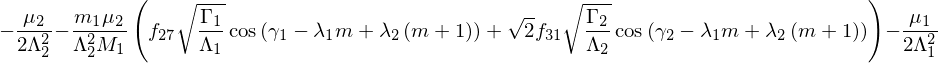

In [56]:
H

In [57]:
Hp = factory(H, actionanglepairs, params)

In [58]:
ic, params = poincare_from_sim(sim, 1, 2, m_res, averaged=True)

In [59]:
m=params['m']
alpha = params['alpha']
f27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))
f31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))        

In [60]:
hp = Hp(**params, f27=f27, f31=f31)

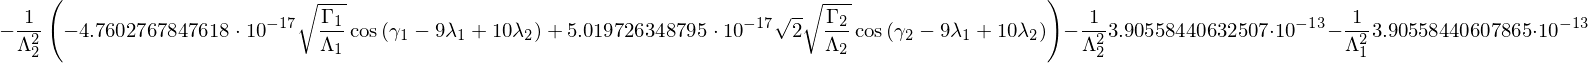

In [61]:
hp.H

In [62]:
%%time
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)
symsol = hp.integrate(ic, times)

Nsol = {'Lambda1':np.zeros(Nout), 'Lambda2':np.zeros(Nout), 'lambda1':np.zeros(Nout), 'lambda2':np.zeros(Nout), 
        'Gamma1':np.zeros(Nout), 'Gamma2':np.zeros(Nout), 'gamma1':np.zeros(Nout), 'gamma2':np.zeros(Nout)}
for i, time in enumerate(times):
    sim.integrate(time)
    var, params = poincare_from_sim(sim, 1, 2, m)
    for key in Nsol.keys():
        Nsol[key][i] = var[key]

CPU times: user 1.22 s, sys: 3.63 ms, total: 1.22 s
Wall time: 1.22 s


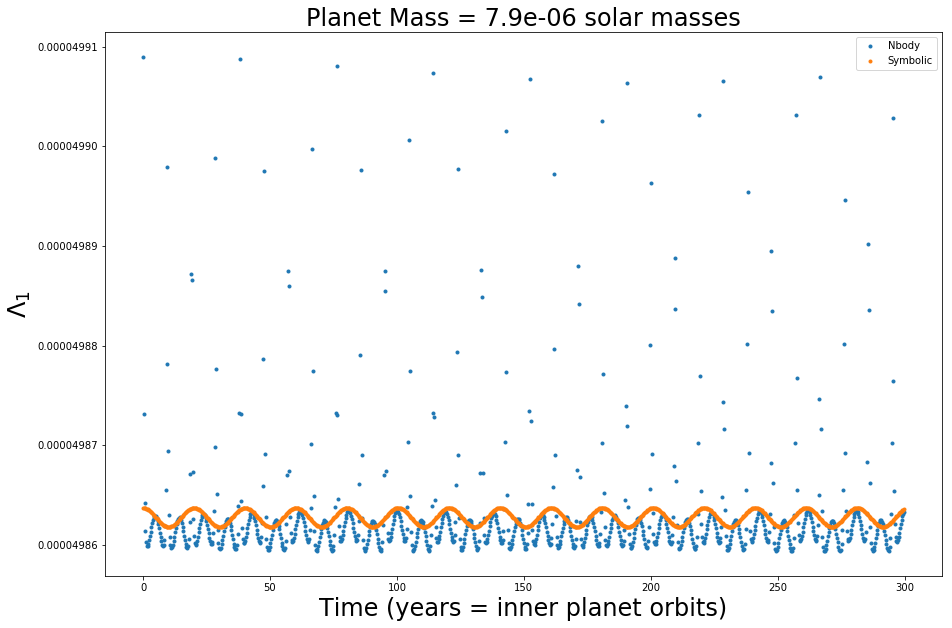

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_1$", fontsize=24)

ax.plot(times, Nsol['Lambda1'], '.', label='Nbody')
ax.plot(times, symsol['Lambda1'], '.', label='Symbolic')

ax.legend()

In [49]:
theta, theta1, Theta, Theta1 = S('theta, theta1, Theta, Theta1')
#Lambda1 = Theta1 - m*Theta
#Lambda2 = (m+1)*Theta
#theta = (m+1)*lambda2 - m*lambda1
#theta1 = lambda1

In [50]:
Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = S('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2')
actionanglepairs = [(Lambda1, lambda1), (Lambda2, lambda2), (Gamma1, gamma1), (Gamma2, gamma2)]
m1, m2, M1, mu1, mu2, alpha, m, f27, f31 = S('m1, m2, M1, mu1, mu2, alpha, m, f27, f31')
params = [m1, M1, mu1, mu2, alpha, m, f27, f31]

H = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2) - m1/M1*mu2/Lambda2**2*(f27*sqrt(Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1) + f31*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)) 

In [51]:
H = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2) - m1/M1*mu2/Lambda2**2*(f27*sqrt(Gamma1/Lambda1)*cos(theta + gamma1) + f31*sqrt(2*Gamma2/Lambda2)*cos(theta + gamma2)) 

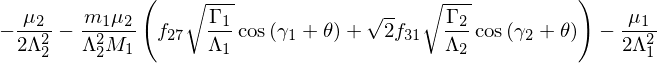

In [52]:
H

In [53]:
Htheta = H.subs(Lambda1, Theta1 - m*Theta)
Htheta = Htheta.subs(Lambda2, (m+1)*Theta)

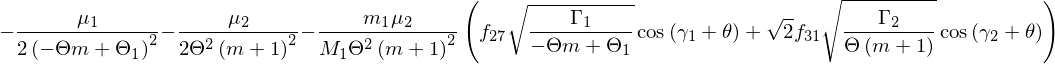

In [54]:
Htheta

In [55]:
# Actionnew = Action/Theta1, Action = Actionnew*Theta1

In [56]:
Htheta = Htheta.subs(Theta, Theta*Theta1)
Htheta = Htheta.subs(Gamma1, Gamma1*Theta1)
Htheta = Htheta.subs(Gamma2, Gamma2*Theta1)

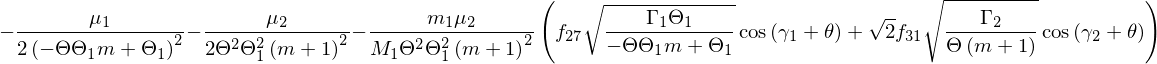

In [57]:
Htheta

In [58]:
Htheta /= mu2/Theta1**2
Htheta = simplify(Htheta)

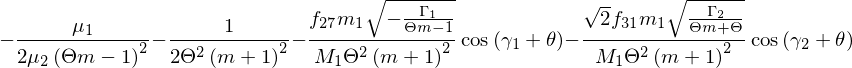

In [59]:
Htheta

In [60]:
Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = S('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2')
actionanglepairs = [(Theta, theta), (Gamma1, gamma1), (Gamma2, gamma2)]
m1, m2, M1, mu1, mu2, alpha, m, f27, f31 = S('m1, m2, M1, mu1, mu2, alpha, m, f27, f31')
params = [m1, M1, mu1, mu2, alpha, m, f27, f31]

In [61]:
Htheta = factory(Htheta, actionanglepairs, params)

In [112]:
def thetas_from_sim(sim, inner, outer, m, averaged=False, scales=None):
    var, params = poincare_from_sim(sim, inner, outer, m, averaged=averaged)
    m=params['m']
    Theta = var['Lambda2']/(m+1)
    Theta1 = m/(m+1)*var['Lambda2'] + var['Lambda1']
    theta = (m+1)*var['lambda2'] - m*var['lambda1']
    theta1 = var['lambda1']
    
    if scales is None:
        scales = {'actionscale':Theta1, 'timescale':Theta1**3/params['mu2']}
    
    actionscale = scales['actionscale']
    var =  {'Theta':Theta/actionscale, 'Theta1':Theta1/actionscale, 'theta':theta, 'theta1':theta1, 'Gamma1':var['Gamma1']/actionscale, 'Gamma2':var['Gamma2']/actionscale, 'gamma1':var['gamma1'], 'gamma2':var['gamma2']}
    return var, params, scales

In [116]:
import rebound
import numpy as np

logmass = -5.1
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 300 # number of inner planet orbits to integrate for
Nout = 1000
m_res=6

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m_res+1)/m_res)
sim.move_to_com()

In [117]:
var0, params, scales = thetas_from_sim(sim, 1, 2, m_res, averaged=True)
m=params['m']
alpha = params['alpha']
f27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))
f31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))        
htheta = Htheta(**params, f27=f27, f31=f31)

In [119]:
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)
timescale = scales['timescale']
normtimes = [t/timescale for t in times]
symsol = htheta.integrate(var0, normtimes)

Nsol = {'Theta':np.zeros(Nout), 'Theta1':np.zeros(Nout), 'theta':np.zeros(Nout), 'theta1':np.zeros(Nout), 
        'Gamma1':np.zeros(Nout), 'Gamma2':np.zeros(Nout), 'gamma1':np.zeros(Nout), 'gamma2':np.zeros(Nout)}
for i, time in enumerate(times):
    sim.integrate(time)
    var, params, scales = thetas_from_sim(sim, 1, 2, m_res, averaged=False, scales=scales)
    for key in Nsol.keys():
        Nsol[key][i] = var[key]

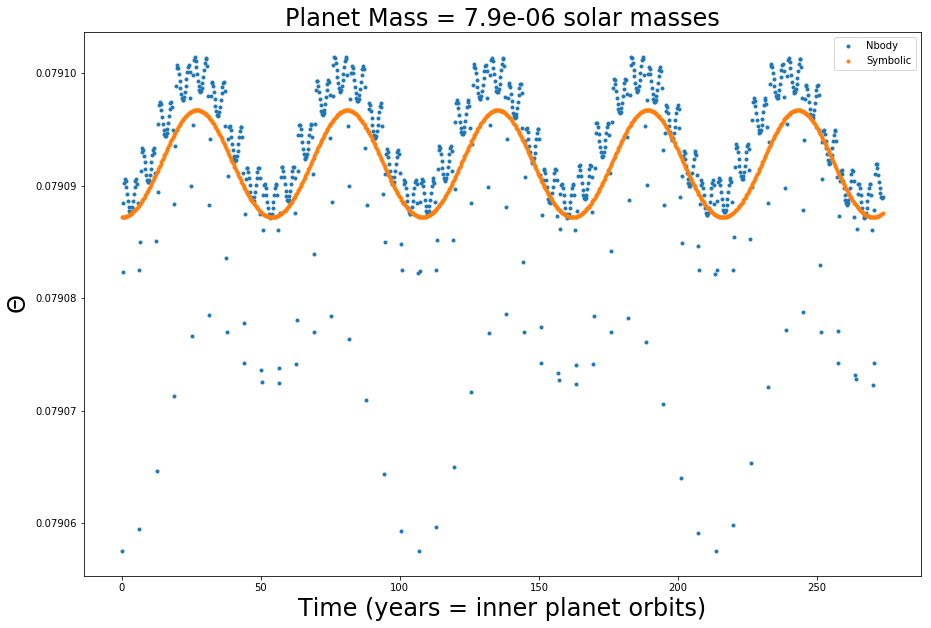

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Theta$", fontsize=24)

ax.plot(normtimes, Nsol['Theta'], '.', label='Nbody')
ax.plot(normtimes, symsol['Theta'], '.', label='Symbolic')

ax.legend()

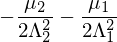

In [25]:
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
H0

In [33]:
dL_1, dL_2 = S('dL_1, dL_2')
H0 = -mu1/(2*((2*m1/m2*sqrt(alpha) + dL_1)**2)) - mu2/(2*(2 + dL_2)**2)

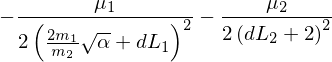

In [34]:
H0

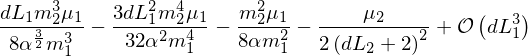

In [54]:
from sympy import series
series(H0, dL_1, 0, 3)

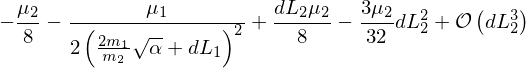

In [56]:
series(H0, dL_2, 0, 3)